In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'


# Download the 10x Dataset `100 1:1 Mixture of Fresh Frozen Human (HEK293T) and Mouse (NIH3T3) Cells`

10x datasets are available at
https://support.10xgenomics.com/single-cell-gene-expression/datasets

The page for the `100 1:1 Mixture of Fresh Frozen Human (HEK293T) and Mouse (NIH3T3) Cells` dataset is
https://support.10xgenomics.com/single-cell-gene-expression/datasets/2.1.0/hgmm_100

The FASTQ files (761 MB) can be downloaded with `curl` directly from http://cf.10xgenomics.com/samples/cell-exp/2.1.0/hgmm_100/hgmm_100_fastqs.tar

In the cell below we check if the dataset file `hgmm_100_fastqs.tar` already exists. If not we download the dataset to the same directory as this notebook


In [2]:
#Check if the file was downloaded already before doing curl:
if not (os.path.isfile('./hgmm_100_fastqs.tar')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O http://cf.10xgenomics.com/samples/cell-exp/2.1.0/hgmm_100/hgmm_100_fastqs.tar
else: print('Dataset already downloaded!')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  760M  100  760M    0     0  59.2M      0  0:00:12  0:00:12 --:--:-- 99.2M


## untar the fastq files on hgmm_100_fastqs folder
Note that this dataset was sequenced from 8 10x lanes (L001-L008).
Hence it has 24 files: read 1 (R1), read 2 (R1), and index (I1) for each lane 

In [3]:
!tar -xvf ./hgmm_100_fastqs.tar

fastqs/
fastqs/hgmm_100_S1_L001_I1_001.fastq.gz
fastqs/hgmm_100_S1_L001_R1_001.fastq.gz
fastqs/hgmm_100_S1_L001_R2_001.fastq.gz
fastqs/hgmm_100_S1_L002_I1_001.fastq.gz
fastqs/hgmm_100_S1_L002_R1_001.fastq.gz
fastqs/hgmm_100_S1_L002_R2_001.fastq.gz
fastqs/hgmm_100_S1_L003_I1_001.fastq.gz
fastqs/hgmm_100_S1_L003_R1_001.fastq.gz
fastqs/hgmm_100_S1_L003_R2_001.fastq.gz
fastqs/hgmm_100_S1_L004_I1_001.fastq.gz
fastqs/hgmm_100_S1_L004_R1_001.fastq.gz
fastqs/hgmm_100_S1_L004_R2_001.fastq.gz
fastqs/hgmm_100_S1_L005_I1_001.fastq.gz
fastqs/hgmm_100_S1_L005_R1_001.fastq.gz
fastqs/hgmm_100_S1_L005_R2_001.fastq.gz
fastqs/hgmm_100_S1_L006_I1_001.fastq.gz
fastqs/hgmm_100_S1_L006_R1_001.fastq.gz
fastqs/hgmm_100_S1_L006_R2_001.fastq.gz
fastqs/hgmm_100_S1_L007_I1_001.fastq.gz
fastqs/hgmm_100_S1_L007_R1_001.fastq.gz
fastqs/hgmm_100_S1_L007_R2_001.fastq.gz
fastqs/hgmm_100_S1_L008_I1_001.fastq.gz
fastqs/hgmm_100_S1_L008_R1_001.fastq.gz
fastqs/hgmm_100_S1_L008_R2_001.fastq.gz


# Buiding the kallisto index

First make sure that kallisto is installed and the version is greater than 0.45

If it's not installed, see instructions at https://pachterlab.github.io/kallisto/download

In [4]:
!kallisto version 

kallisto, version 0.45.0


First we build the kallisto index for the dataset. 
For this index in particular, because this is a species mixing experiment, we have to download the human and mouse transcriptome, concatenate them, and then build the index.
Building the index takes a few minutes and needs to be done only once.

### Download human and mouse reference transcriptomes from ensembl
In order to do that we first download the human and mouse transcriptomes from ensembl. You can see the reference genomes they have at https://uswest.ensembl.org/info/data/ftp/index.html

In [5]:
#Check if the file was downloaded already before doing curl:
if not (os.path.isfile('Mus_musculus.GRCm38.cdna.all.fa.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz
else: print('Mouse transcriptome already downloaded!')

if not (os.path.isfile('Homo_sapiens.GRCh38.cdna.all.fa.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-94/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
else: print('Human transcriptome already downloaded!')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48.4M  100 48.4M    0     0  2037k      0  0:00:24  0:00:24 --:--:-- 3197k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64.7M  100 64.7M    0     0  2676k      0  0:00:24  0:00:24 --:--:-- 5222k


In [6]:
#unzip the human and mouse transcriptomes
!gunzip -v Homo_sapiens.GRCh38.cdna.all.fa.gz
!gunzip -v Mus_musculus.GRCm38.cdna.all.fa.gz

Homo_sapiens.GRCh38.cdna.all.fa.gz:	 81.3% -- replaced with Homo_sapiens.GRCh38.cdna.all.fa
Mus_musculus.GRCm38.cdna.all.fa.gz:	 79.2% -- replaced with Mus_musculus.GRCm38.cdna.all.fa


In [7]:
!cat ./Mus_musculus.GRCm38.cdna.all.fa ./Homo_sapiens.GRCh38.cdna.all.fa > ./human_mouse_contatenated_transcriptome.fa
print('Human and mouse transcriptomes concatenated!')

Human and mouse transcriptomes concatenated!


In [8]:
### Now we can build the index
if not (os.path.isfile('human_mouse_transcriptome_index.idx')): 
    !kallisto index -i human_mouse_transcriptome_index.idx human_mouse_contatenated_transcriptome.fa
else: print ('Human-mouse transcript index already exist!')


[build] loading fasta file human_mouse_contatenated_transcriptome.fa
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 2071 target sequences
[build] warning: replaced 8 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 2138564 contigs and contains 206125484 k-mers 



# Preparing transcript_to_gene.tsv file process the single cell data with kallisto bus

Depending on which transcriptome you used, you will need to create a file translating transcripts to genes. This notebook assumes the file is in `transcript_to_gene.tsv`, for ensembl transcriptomes these can be generated using biomart.

The general format of `transcript_to_gene.tsv` is

```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
ENST00000415118.1	ENSG00000223997.1
ENST00000631435.1	ENSG00000282253.1
...
```

To create the `transcript_to_gene.tsv` we fetch and parse the mouse GTF file from ensembl.

The reference GTF files are available at https://uswest.ensembl.org/info/data/ftp/index.html

The mouse ones which we use are at ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus

In [9]:
#Check if the file was downloaded already before doing curl:
if not (os.path.isfile('Mus_musculus.GRCm38.94.gtf.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-94/gtf/mus_musculus/Mus_musculus.GRCm38.94.gtf.gz
else: print('Mouse GTF already downloaded!')
    
    
#Check if the file was downloaded already before doing curl:
if not (os.path.isfile('Homo_sapiens.GRCh38.94.gtf.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-94/gtf/homo_sapiens/Homo_sapiens.GRCh38.94.gtf.gz
else: print('Human GTC already downloaded!')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.0M  100 28.0M    0     0  1588k      0  0:00:18  0:00:18 --:--:-- 2516k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.6M  100 41.6M    0     0  1804k      0  0:00:23  0:00:23 --:--:-- 2677k


In [10]:
# Unzip the files
!gunzip -v ./Mus_musculus.GRCm38.94.gtf.gz
!gunzip -v ./Homo_sapiens.GRCh38.94.gtf.gz

./Mus_musculus.GRCm38.94.gtf.gz:	 96.2% -- replaced with ./Mus_musculus.GRCm38.94.gtf
./Homo_sapiens.GRCh38.94.gtf.gz:	 96.2% -- replaced with ./Homo_sapiens.GRCh38.94.gtf


In [11]:
# concatenate the GTF files
!cat ./Mus_musculus.GRCm38.94.gtf ./Homo_sapiens.GRCh38.94.gtf > ./human_mouse_contatenated_GTF.gtf
print('Human and mouse GTF files concatenated!')

Human and mouse GTF files concatenated!


## Create transcript_to_gene.tsv

Now we can use the cells below to parse the GTF file and keep only the transcript mapping as a tsv file in the format below.
```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
```

In [12]:
def create_transcript_list(input, use_name = True, use_version = True):
    r = {}
    for line in input:
        if len(line) == 0 or line[0] == '#':
            continue
        l = line.strip().split('\t')
        if l[2] == 'transcript':
            info = l[8]
            d = {}
            for x in info.split('; '):
                x = x.strip()
                p = x.find(' ')
                if p == -1:
                    continue
                k = x[:p]
                p = x.find('"',p)
                p2 = x.find('"',p+1)
                v = x[p+1:p2]
                d[k] = v


            if 'transcript_id' not in d or 'gene_id' not in d:
                continue

            tid = d['transcript_id']
            gid = d['gene_id']
            if use_version:
                if 'transcript_version' not in d or 'gene_version' not in d:
                    continue

                tid += '.' + d['transcript_version']
                gid += '.' + d['gene_version']
            gname = None
            if use_name:
                if 'gene_name' not in d:
                    continue
                gname = d['gene_name']

            if tid in r:
                continue

            r[tid] = (gid, gname)
    return r



def print_output(output, r, use_name = True):
    for tid in r:
        if use_name:
            output.write("%s\t%s\t%s\n"%(tid, r[tid][0], r[tid][1]))
        else:
            output.write("%s\t%s\n"%(tid, r[tid][0]))

In [13]:
with open('./human_mouse_contatenated_GTF.gtf') as file:
    r = create_transcript_list(file, use_name = True, use_version = True)
with open('human_mouse_transcript_to_gene.tsv', "w+") as output:
    print_output(output, r, use_name = True)
print('Created human_mouse_transcript_to_gene.tsv file')

Created human_mouse_transcript_to_gene.tsv file


In [14]:
with open('./Mus_musculus.GRCm38.94.gtf') as file:
    r = create_transcript_list(file, use_name = True, use_version = True)
with open('mouse_transcript_to_gene.tsv', "w+") as output:
    print_output(output, r, use_name = True)
print('Created mouse_transcript_to_gene.tsv file')

Created mouse_transcript_to_gene.tsv file


In [15]:
with open('./Homo_sapiens.GRCh38.94.gtf') as file:
    r = create_transcript_list(file, use_name = True, use_version = True)
with open('human_transcript_to_gene.tsv', "w+") as output:
    print_output(output, r, use_name = True)
print('Created human_transcript_to_gene.tsv file')

Created human_transcript_to_gene.tsv file


# Run kallisto bus
kallisto bus supports several single cell sequencing technologies, as you can see below. We'll be using 10xv2            

In [16]:
!kallisto bus --list

List of supported single cell technologies

short name       description
----------       -----------
10Xv1            10X chemistry version 1
10Xv2            10X chemistry verison 2
DropSeq          DropSeq
inDrop           inDrop
CELSeq           CEL-Seq
CELSeq2          CEL-Seq version 2
SCRBSeq          SCRB-Seq



We are using paired end reads (R1 and R2 files) with 8 samples

In [17]:
!kallisto bus -i human_mouse_transcriptome_index.idx  -o out_hgmm_100 -x 10xv2 -t 4 \
./fastqs/hgmm_100_S1_L001_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L001_R2_001.fastq.gz \
./fastqs/hgmm_100_S1_L002_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L002_R2_001.fastq.gz \
./fastqs/hgmm_100_S1_L003_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L003_R2_001.fastq.gz \
./fastqs/hgmm_100_S1_L004_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L004_R2_001.fastq.gz \
./fastqs/hgmm_100_S1_L005_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L005_R2_001.fastq.gz \
./fastqs/hgmm_100_S1_L006_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L006_R2_001.fastq.gz \
./fastqs/hgmm_100_S1_L007_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L007_R2_001.fastq.gz \
./fastqs/hgmm_100_S1_L008_R1_001.fastq.gz ./fastqs/hgmm_100_S1_L008_R2_001.fastq.gz 



[index] k-mer length: 31
[index] number of targets: 302,896
[index] number of k-mers: 206,125,484
[index] number of equivalence classes: 1,252,306
[quant] will process sample 1: ./fastqs/hgmm_100_S1_L001_R1_001.fastq.gz
                               ./fastqs/hgmm_100_S1_L001_R2_001.fastq.gz
[quant] will process sample 2: ./fastqs/hgmm_100_S1_L002_R1_001.fastq.gz
                               ./fastqs/hgmm_100_S1_L002_R2_001.fastq.gz
[quant] will process sample 3: ./fastqs/hgmm_100_S1_L003_R1_001.fastq.gz
                               ./fastqs/hgmm_100_S1_L003_R2_001.fastq.gz
[quant] will process sample 4: ./fastqs/hgmm_100_S1_L004_R1_001.fastq.gz
                               ./fastqs/hgmm_100_S1_L004_R2_001.fastq.gz
[quant] will process sample 5: ./fastqs/hgmm_100_S1_L005_R1_001.fastq.gz
                               ./fastqs/hgmm_100_S1_L005_R2_001.fastq.gz
[quant] will process sample 6: ./fastqs/hgmm_100_S1_L006_R1_001.fastq.gz
                               ./fastqs/hgmm_100_

### The `matrix.ec` file

The `matrix.ec` is generated by kallisto and connects the equivalence class ids to sets of transcripts. The format looks like
~~~
0	0
1	1
2	2
3	3
4	4
...

884398	26558,53383,53384,69915,69931,85319,109252,125730
884399	7750,35941,114698,119265
884400	9585,70083,92571,138545,138546
884401	90512,90513,134202,159456
~~~

In [18]:
#load transcript to gene file
tr2g = {}
trlist = []
with open('./human_mouse_transcript_to_gene.tsv') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./out_hgmm_100/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

### Processing the BUS file

For these notebooks we will work with the text file that `BUStools` produces, rather than the raw `BUS` file. 
To install `BUStools` see https://github.com/BUStools/bustools

We discard any barcodes that don't have more 10 UMIs 

To produce the text file, starting with the `output.bus` file produced by kallisto, we first sort it on bustools:
```
bustools sort -o output.sorted output.bus
```
Then we convert it to txt:
```
bustools text -o output.sorted.txt output.sorted
```



In [19]:
#sort bus file
!bustools sort -o ./out_hgmm_100/output_sorted.bus ./out_hgmm_100/output.bus

Read in 5933252 number of busrecords
All sorted


In [20]:
# convert the sorted busfile to txt
!bustools text -o ./out_hgmm_100/output_sorted.txt ./out_hgmm_100/output_sorted.bus

Read in 4847729 number of busrecords


# Loading the generated data  

In [21]:
#load human_mouse transcripts

tr2g = {}
trlist = []
with open('./human_mouse_transcript_to_gene.tsv') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./out_hgmm_100/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

In [22]:
# load kallisto bus output dataset

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./out_hgmm_100/output_sorted.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]



In [23]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s
    

# Take a look at the detected barcodes and genes

9051


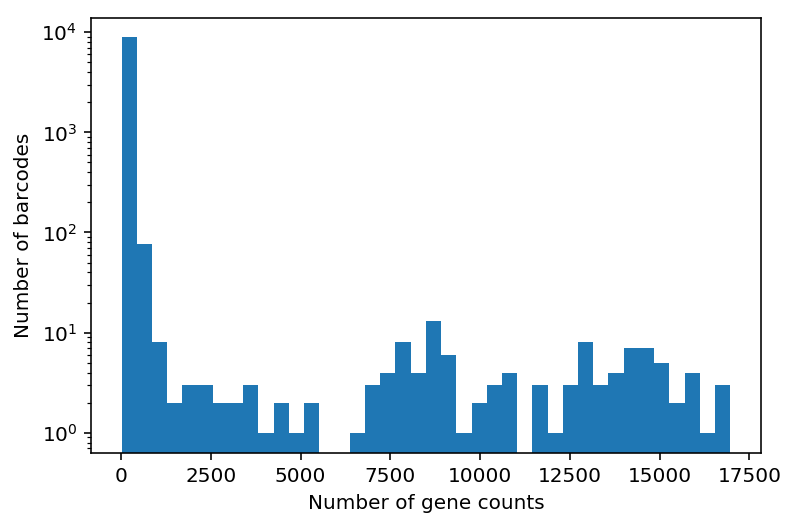

In [24]:
threshold = 0 # this filters the data by gene count
bcv = [x for b,x in barcode_hist.items() if x > threshold] 
_ = plt.hist(bcv,bins=40, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
print(len(bcv))

# Export count data as `.mtx`

In [25]:
outfile = './out_hgmm_100/matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 500  and x < 10000]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])



In [26]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))
    

In [27]:
gene_names = {}
with open('./human_mouse_transcript_to_gene.tsv') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


In [28]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('./out_hgmm_100/genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('./out_hgmm_100/barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')

# Plot PCA

In [29]:
from scipy.io import mmread
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [31]:
count_matrix = mmread('./out_hgmm_100/matrix.mtx')
count_matrix

<113267x119 sparse matrix of type '<class 'numpy.float64'>'
	with 236294 stored elements in COOrdinate format>

In [37]:
dense_count_matrix = count_matrix.todense()
counts_df = pd.DataFrame(dense_count_matrix)
# Take a peek at what the count matrix look like
counts_df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
pca = PCA(n_components=20)
pca.fit(dense_count_matrix)
pca_points1 = pca.transform(dense_count_matrix)


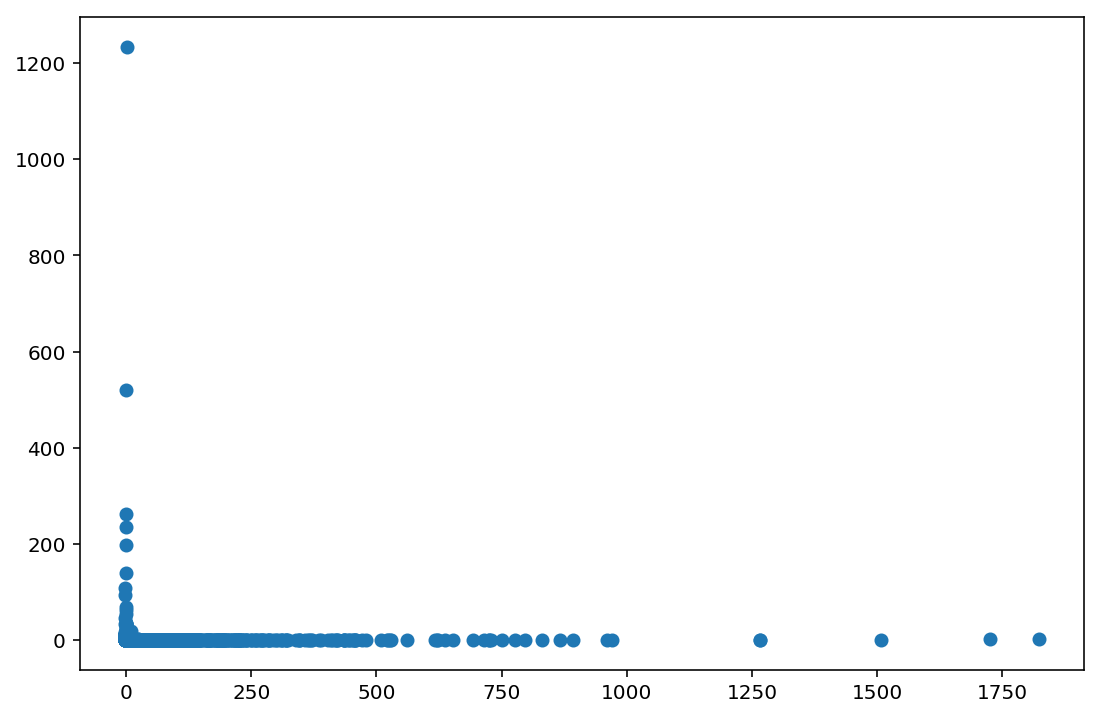

In [39]:
pca_x1 = pca_points1[:,:1,].flatten()
pca_y1 = pca_points1[:,1:2,].flatten()

matplotlib.pyplot.scatter(pca_x1,pca_y1)
plt.show()

# Load gene count matrix, genes and barcodes for plotting

In [40]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from scipy.stats import gaussian_kde

In [41]:
adata = sc.read('./out_hgmm_100/matrix.mtx', cache=False).T  # transpose the data
adata.var_names = pd.read_csv('./out_hgmm_100/genes.tsv', header=None,)[0]
adata.obs_names = pd.read_csv('./out_hgmm_100/barcodes.tsv', header=None)[0]

## Get gene counts for human genes and mouse genes for each cell barcode

In [42]:
human_genes = [name for name in adata.var_names if name.startswith('ENSG')]
mouse_genes = [name for name in adata.var_names if name.startswith('ENSMUSG')]
# for each cell compute counts in human genes and mouse genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['counts_human'] = np.sum(adata[:, human_genes].X, axis=1).A1
adata.obs['counts_mouse'] = np.sum(adata[:, mouse_genes].X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['counts_total'] = adata.X.sum(axis=1).A1

#### Check total number of cell barcodes

In [43]:
print('Total number of cell barcodes:',len(adata.obs))

Total number of cell barcodes: 119


#### Check number of cell barcodes with both human & mouse transcripts detected (at least 5% of total transcripts)

In [44]:
print('Number of barcodes with more than 5% mixed transcripts:')
len(adata.obs[(adata.obs['counts_human']>adata.obs['counts_total']*0.05) & (adata.obs['counts_mouse']>adata.obs['counts_total']*0.05)])

Number of barcodes with more than 5% mixed transcripts:


61

# Generate barnyard plot

A barnyard plot is a scatterplot to show counts of one species transcripts vs. counts of the other species transcripts for each cell barcode

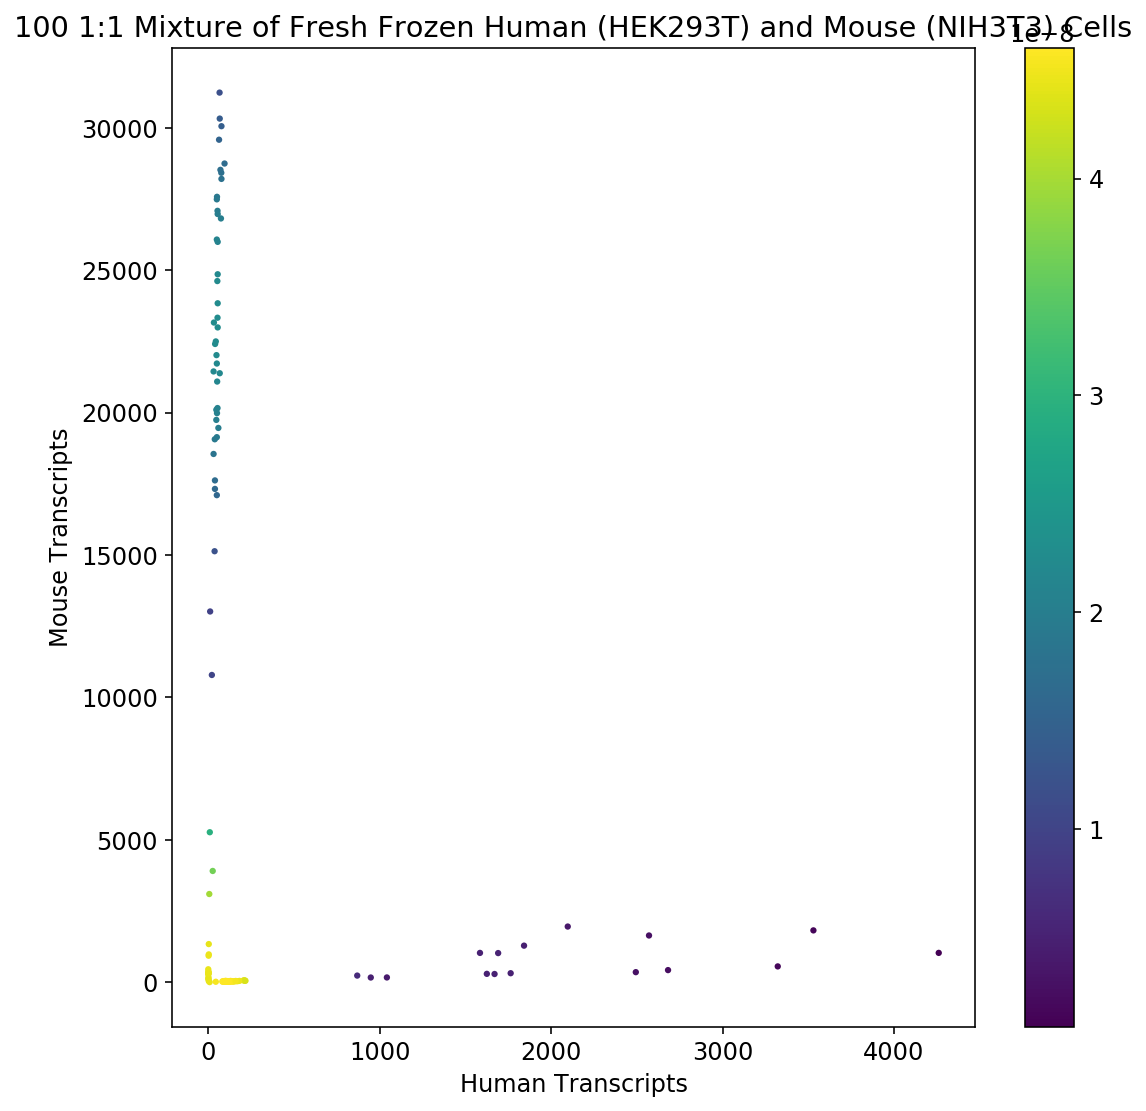

In [45]:
xy = np.vstack([adata.obs['counts_human'], adata.obs['counts_mouse']])
z = gaussian_kde(xy)(xy)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,9))
plt.scatter(adata.obs['counts_human'], adata.obs['counts_mouse'], c=z, s=10, edgecolor='')
plt.title('100 1:1 Mixture of Fresh Frozen Human (HEK293T) and Mouse (NIH3T3) Cells')
plt.xlabel('Human Transcripts')
plt.ylabel('Mouse Transcripts')
plt.colorbar()
plt.show()